In [1]:
# Control variable: Set to True to skip training and only load/visualize existing results
# Useful for viewing history, plotting curves, or running inference without training
SKIP_TRAINING = False  # Set to True to skip the training loop

## 1. Setup & Imports

In [2]:
import warnings

from pathlib import Path
import numpy as np
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import cv2

from src.degradations.generate_degraded_dataset import generate_degraded_dataset
from src.losses.combined_loss import CombinedLoss
from src.models.unet import UNet
from src.training import get_dataloaders, run_training
from src.utils import (
    get_degraded_data_dir,
    get_raw_data_dir,
    load_checkpoint,
    plot_image_comparison,
    plot_inference_results,
    plot_training_curves,
    print_training_summary,
    setup_or_resume_experiment,
    resume_training,
    download_div2k_dataset,
)
from src.evaluation import ImageRestorationEvaluator

warnings.filterwarnings("ignore")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(
        f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
    )

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070 SUPER
CUDA memory: 12.88 GB


## 2. Configuration

In [ ]:
# Training configuration
config = {
    # Resume Training
    "resume_from_checkpoint": False,  # Set to True to resume from latest checkpoint
    "resume_experiment": "latest",  # "latest" or specific timestamp like "20251229_224726"
    # Data
    "train_degraded_dir": str(
        get_degraded_data_dir() / "dithering" / "random" / "DIV2K_train_HR"
    ),
    "train_clean_dir": str(get_raw_data_dir() / "DIV2K_train_HR"),
    "val_degraded_dir": str(
        get_degraded_data_dir() / "dithering" / "random" / "DIV2K_valid_HR"
    ),
    "val_clean_dir": str(get_raw_data_dir() / "DIV2K_valid_HR"),
    # Training
    "batch_size": 48,
    "num_epochs": 35,
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    # Data
    "patch_size": 128,
    "patches_per_image": 10,
    "num_workers": 8,
    # Model
    "model_features": 96,
    "model_bilinear": True,
    # Loss
    "loss_alpha": 0.84,  # L1 weight
    "loss_beta": 0.16,  # SSIM weight
    # Degradation
    "bits_per_channel": 2,  # Quantization bits
    "dithering_type": "random",  # Dithering type
    # Optimization
    "scheduler": "cosine",
    "warmup_epochs": 5,
    "min_lr": 1e-6,
    # Early stopping
    "patience": 5,
    # Checkpoints
    "save_every": 5,
    "val_every": 1,
    # Mixed Precision
    "use_amp": True,
    # Device
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}

# Set seed for reproducibility
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True  # True for exam reproducibility
    torch.backends.cudnn.benchmark = True      # True for performance optimization

print("\n📋 Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")


📋 Configuration:
   resume_from_checkpoint: False
   resume_experiment: latest
   train_degraded_dir: c:\Users\giuse\Codici\Workspace\Image-Enhancement\data\degraded\dithering\random\DIV2K_train_HR
   train_clean_dir: c:\Users\giuse\Codici\Workspace\Image-Enhancement\data\raw\DIV2K_train_HR
   val_degraded_dir: c:\Users\giuse\Codici\Workspace\Image-Enhancement\data\degraded\dithering\random\DIV2K_valid_HR
   val_clean_dir: c:\Users\giuse\Codici\Workspace\Image-Enhancement\data\raw\DIV2K_valid_HR
   batch_size: 64
   num_epochs: 35
   learning_rate: 0.0001
   weight_decay: 1e-05
   patch_size: 192
   patches_per_image: 10
   num_workers: 8
   model_features: 64
   model_bilinear: True
   loss_alpha: 0.84
   loss_beta: 0.16
   bits_per_channel: 2
   dithering_type: random
   scheduler: cosine
   warmup_epochs: 5
   min_lr: 1e-06
   patience: 5
   save_every: 5
   val_every: 1
   use_amp: True
   device: cuda
   seed: 42


## 3. Create Output Directories

In [4]:
# Setup experiment directories (new or resume existing)
exp_dir, checkpoints_dir, samples_dir, logs_dir = setup_or_resume_experiment(
    model_name="unet",
    degradation="dithering/random",
    config=config,
    resume_from_checkpoint=config["resume_from_checkpoint"],
    resume_experiment=config["resume_experiment"],
    custom_name="v1",
)


📁 Experiment: 20260102_185215_v1


## 4. Setup TensorBoard

In [5]:
# TensorBoard writer
writer = SummaryWriter(log_dir=logs_dir)

print(f"\n📊 TensorBoard logs: {logs_dir}")
print(f"   Run: tensorboard --logdir {logs_dir.absolute()}")


📊 TensorBoard logs: c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_185215_v1\logs
   Run: tensorboard --logdir c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_185215_v1\logs


## 5. Generate Degraded Datasets

Generate corrupted versions of DIV2K images using 2-bit random dithering

In [6]:
# Check if raw datasets exist, if not download them
train_clean_exists = Path(config["train_clean_dir"]).exists()
val_clean_exists = Path(config["val_clean_dir"]).exists()

if not train_clean_exists or not val_clean_exists:
    print("=" * 80)
    print("📥 DIV2K Dataset Not Found - Downloading...")
    print("=" * 80)
    download_div2k_dataset()
else:
    print("✅ DIV2K raw dataset already exists")

# Check if degraded datasets already exist
train_degraded_exists = Path(config["train_degraded_dir"]).exists()
val_degraded_exists = Path(config["val_degraded_dir"]).exists()

if train_degraded_exists and val_degraded_exists:
    n_train = len(list(Path(config["train_degraded_dir"]).glob("*.png")))
    n_val = len(list(Path(config["val_degraded_dir"]).glob("*.png")))
    print("✅ Degraded datasets already exist:")
    print(f"   Train: {n_train} images in {config['train_degraded_dir']}")
    print(f"   Val: {n_val} images in {config['val_degraded_dir']}")
    print("\n⏭️  Skipping generation (delete folders to regenerate)")
else:
    print("=" * 80)
    print("🎨 Generating Degraded Datasets")
    print("=" * 80)
    print("\nDegradation: 2-bit random dithering")
    print("This will create corrupted versions of DIV2K images\n")

    # Generate training dataset
    if not train_degraded_exists:
        print("📂 Training Dataset")
        generate_degraded_dataset(
            input_dir=config["train_clean_dir"],
            output_dir=config["train_degraded_dir"],
            degradation_type="quantization",
            bits_per_channel=2,
            dithering_type="random",
            seed=config["seed"],
        )

    # Generate validation dataset
    if not val_degraded_exists:
        print("📂 Validation Dataset")
        generate_degraded_dataset(
            input_dir=config["val_clean_dir"],
            output_dir=config["val_degraded_dir"],
            degradation_type="quantization",
            bits_per_channel=2,
            dithering_type="random",
            seed=config["seed"],
        )

    print("=" * 80)
    print("✅ Degraded datasets generated successfully!")
    print("=" * 80)

✅ DIV2K raw dataset already exists
✅ Degraded datasets already exist:
   Train: 800 images in c:\Users\giuse\Codici\Workspace\Image-Enhancement\data\degraded\dithering\random\DIV2K_train_HR
   Val: 100 images in c:\Users\giuse\Codici\Workspace\Image-Enhancement\data\degraded\dithering\random\DIV2K_valid_HR

⏭️  Skipping generation (delete folders to regenerate)


## 6. Create Dataloaders

In [7]:
# Create dataloaders
train_loader, val_loader = get_dataloaders(
    train_degraded_dir=config["train_degraded_dir"],
    train_clean_dir=config["train_clean_dir"],
    val_degraded_dir=config["val_degraded_dir"],
    val_clean_dir=config["val_clean_dir"],
    batch_size=config["batch_size"],
    patch_size=config["patch_size"],
    patches_per_image=config["patches_per_image"],
    num_workers=config["num_workers"],
)

print(f"\n   Batches per epoch: {len(train_loader)} train, {len(val_loader)} val")

📊 Dataset Summary:
   Train: 8000 patches from 800 images
   Val:   1000 patches from 100 images
   Batch size: 64
   Patch size: 192x192

   Batches per epoch: 125 train, 16 val


## 7. Visualize Sample Batch

Batch shapes:
   Degraded: torch.Size([64, 3, 192, 192])
   Clean: torch.Size([64, 3, 192, 192])
   Range: [-1.000, 1.000]


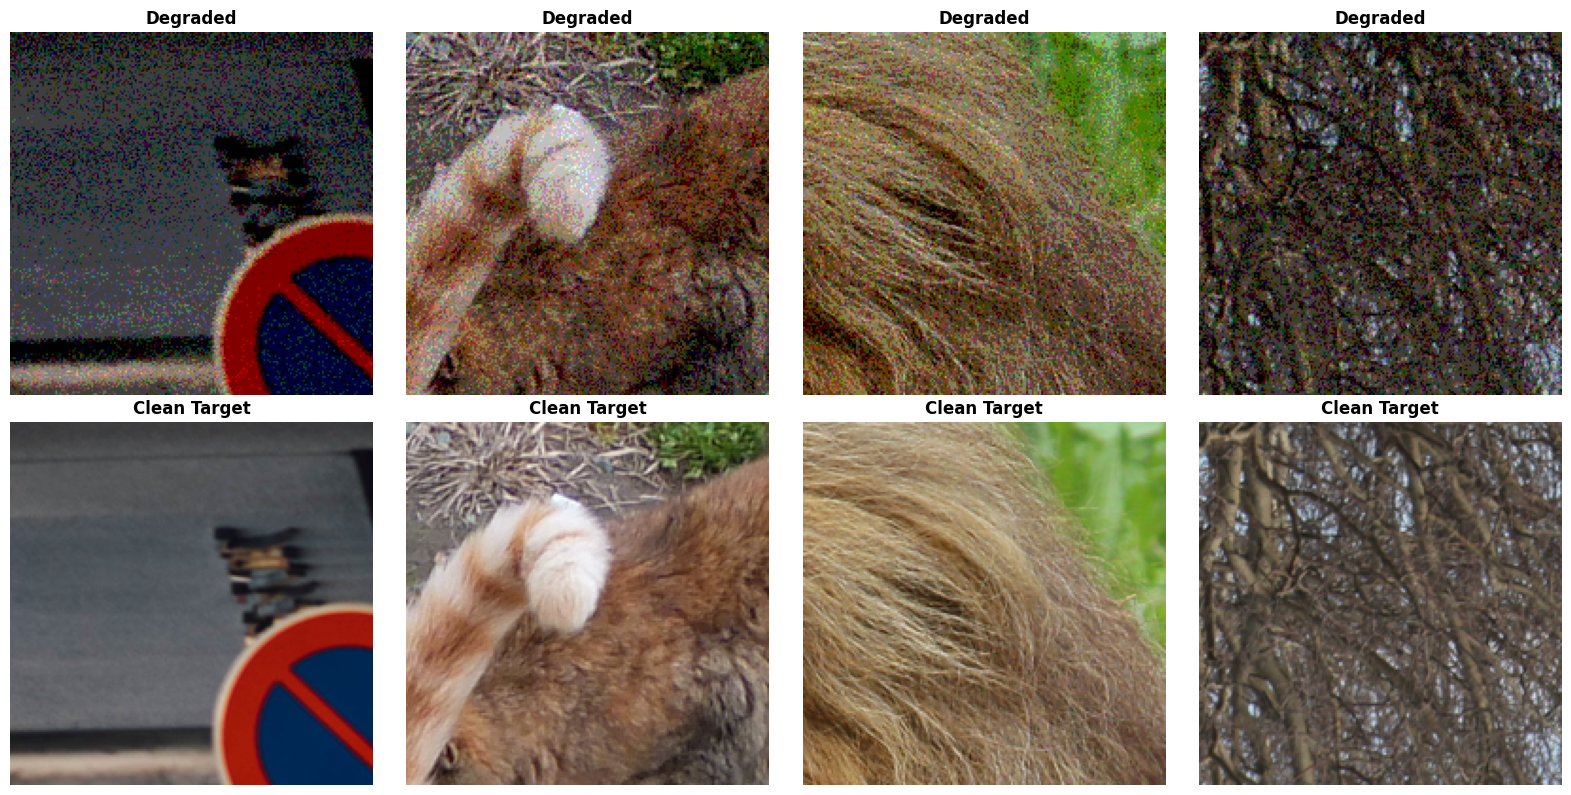


✅ Sample batch saved to c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\unet\dithering\random\20260102_185215_v1\samples\training_samples.png


In [8]:
# Visualize a batch
degraded_batch, clean_batch = next(iter(train_loader))

print("Batch shapes:")
print(f"   Degraded: {degraded_batch.shape}")
print(f"   Clean: {clean_batch.shape}")
print(f"   Range: [{degraded_batch.min():.3f}, {degraded_batch.max():.3f}]")

# Show sample using utility function
plot_image_comparison(
    degraded_batch=degraded_batch,
    clean_batch=clean_batch,
    n_samples=4,
    save_path=samples_dir / "training_samples.png",
)

print(f"\n✅ Sample batch saved to {samples_dir / 'training_samples.png'}")

## 8. Initialize Model, Loss, Optimizer

In [9]:
# Create model
model = UNet(
    in_channels=3,
    out_channels=3,
    features=config["model_features"],
    bilinear=config["model_bilinear"],
).to(config["device"])

print("\n🤖 Model: UNet")
print(f"   Parameters: {model.get_num_params():,}")
print(f"   Device: {config['device']}")

# Loss function
criterion = CombinedLoss(alpha=config["loss_alpha"], beta=config["loss_beta"]).to(
    config["device"]
)

print(f"\n📉 Loss: L1 + SSIM (α={config['loss_alpha']}, β={config['loss_beta']})")

# Optimizer
optimizer = optim.AdamW(
    model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
)

print("\n⚙️  Optimizer: AdamW")
print(f"   Learning rate: {config['learning_rate']}")
print(f"   Weight decay: {config['weight_decay']}")

# Learning rate scheduler
scheduler = None
if config["scheduler"] == "cosine":
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config["num_epochs"] - config["warmup_epochs"],
        eta_min=config["min_lr"],
    )
    print("\n📅 Scheduler: CosineAnnealingLR")
    print(f"   Warmup epochs: {config['warmup_epochs']}")
    print(f"   Min LR: {config['min_lr']}")
else:
    print("\n📅 No scheduler configured")

# Resume from checkpoint if enabled
start_epoch = 0
initial_best_loss = float("inf")
initial_best_epoch = 0
initial_history = None

if config["resume_from_checkpoint"]:
    (
        checkpoint_info,
        start_epoch,
        initial_history,
        resume_exp_dir,
        initial_best_epoch,
    ) = resume_training(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        experiment_path=config["resume_experiment"],
        model_name="unet",
        degradation="dithering/random",
        device=config["device"],
    )
    initial_best_loss = (
        checkpoint_info["metrics"].get("val", {}).get("loss", float("inf"))
    )

    # Verify that resume_exp_dir matches our exp_dir
    if resume_exp_dir != exp_dir:
        print("⚠️  Warning: Resume experiment mismatch!")
        print(f"   Expected: {exp_dir}")
        print(f"   Got: {resume_exp_dir}")
        print(f"   Using: {exp_dir}")
else:
    print("\n🆕 Starting fresh training (resume_from_checkpoint=False)")


🤖 Model: UNet
   Parameters: 17,263,107
   Device: cuda

📉 Loss: L1 + SSIM (α=0.84, β=0.16)

⚙️  Optimizer: AdamW
   Learning rate: 0.0001
   Weight decay: 1e-05

📅 Scheduler: CosineAnnealingLR
   Warmup epochs: 5
   Min LR: 1e-06

🆕 Starting fresh training (resume_from_checkpoint=False)


## 9. Training Loop

In [ ]:
if not SKIP_TRAINING:
    # Run training
    history, best_info = run_training(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=config["device"],
        num_epochs=config["num_epochs"],
        checkpoints_dir=checkpoints_dir,
        writer=writer,
        warmup_epochs=config["warmup_epochs"],
        learning_rate=config["learning_rate"],
        patience=config["patience"],
        save_every=config["save_every"],
        val_every=config["val_every"],
        start_epoch=start_epoch,
        initial_best_loss=initial_best_loss,
        initial_best_epoch=initial_best_epoch,  # Pass best epoch from checkpoint
        initial_history=initial_history,  # Continue from previous history
        use_amp=config["use_amp"],  # Enable/disable mixed precision training
    )

    # Extract best model info
    best_epoch = best_info["best_epoch"]
    best_val_loss = best_info["best_val_loss"]

    print(f"✅ Training history saved to {exp_dir / 'history.json'}")
else:
    # Skip training: Load existing history and best model info
    print("\n" + "=" * 80)
    print("⏭️  SKIP_TRAINING = True: Loading existing results")
    print("=" * 80 + "\n")

    from src.utils.experiment import load_training_history

    try:
        history = load_training_history(exp_dir)
        print(f"✅ Loaded history from {exp_dir / 'history.json'}")
        print(f"   Total epochs: {len(history['train_loss'])}")

        # Find best epoch from history
        if history.get("val_loss"):
            best_val_loss = min(history["val_loss"])
            best_epoch = history["val_loss"].index(best_val_loss) + 1
            print(f"   Best epoch: {best_epoch} (val_loss: {best_val_loss:.4f})")
        else:
            best_val_loss = float("inf")
            best_epoch = 0
            print("   No validation history found")

        # Create best_info dict for consistency
        best_info = {"best_epoch": best_epoch, "best_val_loss": best_val_loss}

    except FileNotFoundError:
        print(f"⚠️  No history found in {exp_dir}")
        print("   Creating empty history (train first to generate data)")
        history = {
            "train_loss": [],
            "train_l1": [],
            "train_ssim": [],
            "val_loss": [],
            "val_l1": [],
            "val_ssim": [],
            "lr": [],
        }
        best_epoch = 0
        best_val_loss = float("inf")
        best_info = {"best_epoch": best_epoch, "best_val_loss": best_val_loss}

    print("=" * 80 + "\n")

⚡ Mixed Precision Training: ENABLED (fp16)

🚀 Starting Training
   Epochs: 1 to 35



Epoch 1 [Train]:   0%|          | 0/125 [00:16<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 1/35
  Train - Loss: 0.3064 | L1: 0.2381 | SSIM: 0.335
  Val   - Loss: 0.1874 | L1: 0.1272 | SSIM: 0.497
  LR: 0.000020 | Time: 147.6s (inference: 21.1s) | VRAM: 270MB
  ✅ Best model saved! (val_loss: 0.1874)
--------------------------------------------------------------------------------


Epoch 2 [Train]:   0%|          | 0/125 [00:16<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 2/35
  Train - Loss: 0.1660 | L1: 0.1138 | SSIM: 0.560
  Val   - Loss: 0.1348 | L1: 0.0873 | SSIM: 0.616
  LR: 0.000040 | Time: 135.1s (inference: 21.0s) | VRAM: 270MB
  ✅ Best model saved! (val_loss: 0.1348)
--------------------------------------------------------------------------------


Epoch 3 [Train]:   0%|          | 0/125 [00:18<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/16 [00:00<?, ?it/s]

## 10. Plot Training Curves

In [ ]:
# Plot training curves using utility function
plot_training_curves(history=history, save_path=exp_dir / "training_curves.png")

print(f"\n✅ Training curves saved to {exp_dir / 'training_curves.png'}")

## 11. Test Inference on Validation Samples

In [ ]:
# Load best model
checkpoint_info = load_checkpoint(
    checkpoints_dir / "best_model.pth", model=model, device=config["device"]
)

print(f"✅ Loaded best model from epoch {checkpoint_info['epoch']}")

# Get validation batch
degraded_batch, clean_batch = next(iter(val_loader))
degraded_batch = degraded_batch.to(config["device"])
clean_batch = clean_batch.to(config["device"])

# Inference
with torch.no_grad():
    restored_batch = model(degraded_batch)

# Visualize results using utility function
plot_inference_results(
    degraded_batch=degraded_batch,
    restored_batch=restored_batch,
    clean_batch=clean_batch,
    n_samples=4,
    save_path=samples_dir / "inference_results.png",
)

print(f"\n✅ Inference results saved to {samples_dir / 'inference_results.png'}")

## 12. Summary

In [ ]:
# Print training summary
print_training_summary(
    history=history,
    best_epoch=best_epoch,
    best_val_loss=best_val_loss,
    exp_dir=exp_dir,
    checkpoints_dir=checkpoints_dir,
    samples_dir=samples_dir,
    logs_dir=logs_dir,
)

## 13. Quantitative Evaluation on Full-Resolution Images

Evaluate the model on entire validation images using sliding window inference.

In [ ]:
# Create evaluator
evaluator = ImageRestorationEvaluator(
    model=model,
    device=config["device"],
    patch_size=config["patch_size"],
    overlap=32,  # Overlap for smooth blending
)

print("\n🔍 Evaluator configured:")
print(f"   Patch size: {config['patch_size']}")
print("   Overlap: 32 pixels")
print(f"   Device: {config['device']}")

In [ ]:
# Evaluate on validation set (limit to 10 images for speed)
eval_results = evaluator.evaluate_dataset(
    degraded_dir=config["val_degraded_dir"],
    clean_dir=config["val_clean_dir"],
    output_dir=exp_dir / "restored_images",
    save_outputs=True,  # Save restored images
    max_images=10,  # Change to None to evaluate all images
)

# Print summary
evaluator.print_summary(eval_results)

# Save results
evaluator.save_results(eval_results, exp_dir / "evaluation_metrics.json")

## 14. Visualize Full-Resolution Restoration

Show best and worst restoration results on full images.

In [ ]:
# Get best and worst images
best_img = max(eval_results["per_image"], key=lambda x: x["psnr"])
worst_img = min(eval_results["per_image"], key=lambda x: x["psnr"])


# Load images for visualization
def load_image_trio(filename):
    degraded_path = Path(config["val_degraded_dir"]) / filename
    clean_path = Path(config["val_clean_dir"]) / filename
    restored_path = exp_dir / "restored_images" / filename

    degraded = cv2.cvtColor(cv2.imread(str(degraded_path)), cv2.COLOR_BGR2RGB)
    clean = cv2.cvtColor(cv2.imread(str(clean_path)), cv2.COLOR_BGR2RGB)
    restored = cv2.cvtColor(cv2.imread(str(restored_path)), cv2.COLOR_BGR2RGB)

    return degraded, restored, clean


# Visualize best result
print(f"\n🏆 Best result: {best_img['filename']}")
print(f"   PSNR: {best_img['psnr']:.2f} dB, SSIM: {best_img['ssim']:.4f}")

deg, res, cln = load_image_trio(best_img["filename"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(deg)
axes[0].set_title("Degraded")
axes[0].axis("off")
axes[1].imshow(res)
axes[1].set_title(f"Restored\nPSNR: {best_img['psnr']:.2f} dB")
axes[1].axis("off")
axes[2].imshow(cln)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.suptitle(f"Best Result: {best_img['filename']}", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(samples_dir / "best_full_restoration.png", dpi=150, bbox_inches="tight")
plt.show()

# Visualize worst result
print(f"\n⚠️ Worst result: {worst_img['filename']}")
print(f"   PSNR: {worst_img['psnr']:.2f} dB, SSIM: {worst_img['ssim']:.4f}")

deg, res, cln = load_image_trio(worst_img["filename"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(deg)
axes[0].set_title("Degraded")
axes[0].axis("off")
axes[1].imshow(res)
axes[1].set_title(f"Restored\nPSNR: {worst_img['psnr']:.2f} dB")
axes[1].axis("off")
axes[2].imshow(cln)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.suptitle(f"Worst Result: {worst_img['filename']}", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(samples_dir / "worst_full_restoration.png", dpi=150, bbox_inches="tight")
plt.show()